In [28]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
from walidacja_funkcji import *

In [29]:
GENERATOR_SAMPLES_TO_RETURN = 768
BATCH_SIZE = 128

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

In [188]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim):
        super(CouplingLayer, self).__init__()
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim)
        )

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
        )

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1e-3)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.translate_net(x), self.scale_net(x)


class NormalizingFlows(nn.Module):
    def __init__(self, input_dim, num_coupling_layers, lr=1e-4):
        super(NormalizingFlows, self).__init__()
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_dim) for _ in range(num_coupling_layers)
        ])
        self.optim = optim.Adam(self.parameters(), lr)

    def check_if_size_is_odd(self, vector):
        if vector.size(-1) % 2 == 1:
            raise ValueError("input dimension is odd, make it even.")

    def forward(self, input_vector):
        layer_output = input_vector.clone()
        log_det_jacobi = 0

        for i, coupling_layer in enumerate(self.coupling_layers):
            self.check_if_size_is_odd(layer_output)
            div_indx = layer_output.size(-1) // 2
            x = layer_output[:, :, :div_indx].squeeze()
            y = layer_output[:, :, div_indx:].squeeze()

            translate_out, scaled = coupling_layer(x)

            log_det_jacobi += scaled.sum(dim=-1) # det(J) = exp(sum(s(x))) = s(x_ij)

            y = y * torch.exp(scaled) + translate_out

            if torch.any(y > 1e10) or torch.isnan(y).any():
                print(f"Layer {i}: Large y values detected")
                print(f"Max y: {y.max().item()}")
                raise ValueError(f'Large value detected: scaled max={scaled.max()}, translate max={translate_out.max()}')

            layer_output = torch.stack([x, y], dim=2)

        return layer_output, log_det_jacobi

    def inverse(self, input_vector):
        layer_output = input_vector.clone()

        for coupling_layer in reversed(self.coupling_layers):
            self.check_if_size_is_odd(layer_output)
            div_indx = layer_output.size(-1) // 2
            x = layer_output[:, :, :div_indx].squeeze()
            y = layer_output[:, :, div_indx:].squeeze()

            translate_out, scaled = coupling_layer(x)
            y = (y - translate_out) * torch.exp(-scaled)

            layer_output = torch.stack([x, y], dim=2)

        return layer_output

    def training_step(self, batched_vector):
        self.zero_grad()
        transformed_data, log_det_jacobi = self.forward(batched_vector)

        log_det_jacobi = log_det_jacobi.mean()
        log_prob_base = 0.5 * (transformed_data ** 2).sum(dim=2).mean()

        loss = log_det_jacobi - log_prob_base
        loss.backward()
        self.optim.step()

        return loss.item()


size = GENERATOR_SAMPLES_TO_RETURN // 2
num_coupling_layers = 4

coupling_layers = NormalizingFlows(input_dim=size, num_coupling_layers=num_coupling_layers, lr=1e-5)

EPOCHS = 1_000
loss_history = np.empty(EPOCHS)

for epoch in range(EPOCHS):
    if epoch % 10 == 0:
        print(f'\r{epoch=}', end='', flush=True)
    
    vector_input = get_2d_data(PROBE_SIZE=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN).T
    vector_input = torch.Tensor(vector_input).reshape(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN // 2, 2)
    loss_history[epoch] = coupling_layers.training_step(vector_input)

epoch=990

In [189]:
vector_input = get_2d_data(PROBE_SIZE=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN).T
vector_input = torch.Tensor(vector_input).reshape(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN // 2, 2)
output, _ = coupling_layers.forward( vector_input )
inversed = coupling_layers.inverse( output )

Text(0, 0.5, 'strata')

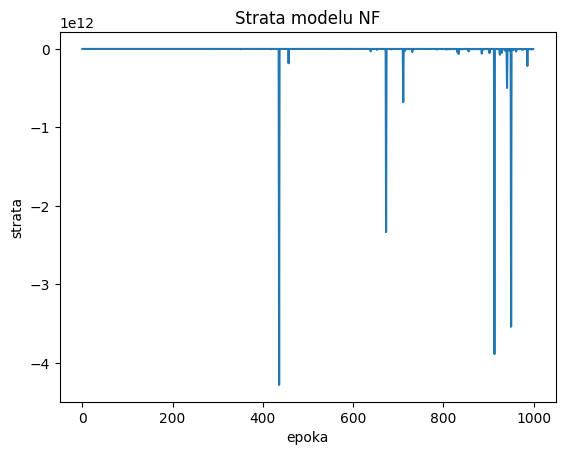

In [190]:
plt.title('Strata modelu NF')
plt.plot(loss_history)
plt.xlabel('epoka')
plt.ylabel('strata')

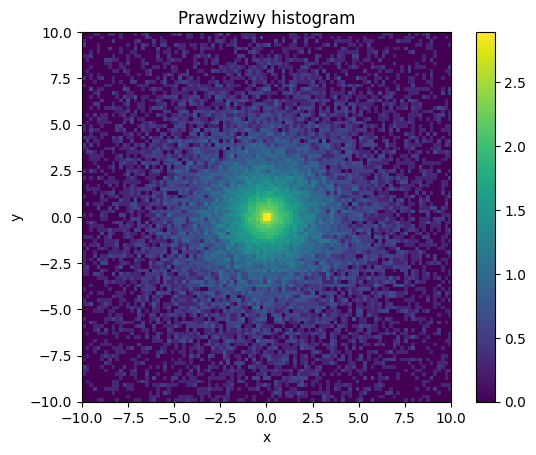

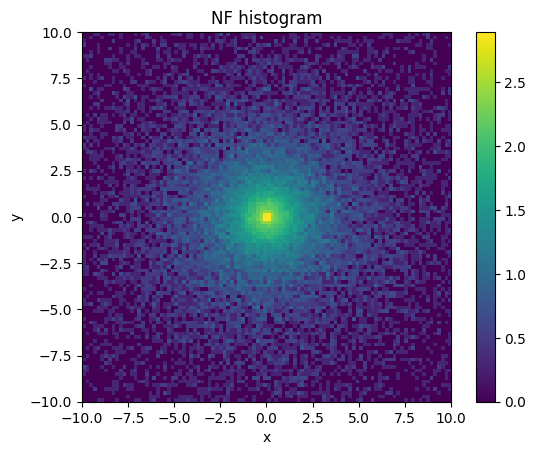

In [185]:
inversed_np = inversed.reshape(-1, 2).detach().numpy()
vector_input_np = vector_input.reshape(-1, 2)
vector_input_np = vector_input_np.detach().numpy() if isinstance(vector_input_np, torch.Tensor) else vector_input_np
inversed_histogram, x_edges, y_edges = np.histogram2d(inversed_np[:, 0], inversed_np[:, 1], range=[[-10, 10], [-10, 10]], bins=100)
true_histogram, x_true_edges, y_true_edges = np.histogram2d(vector_input_np[:, 0], vector_input_np[:, 1], range=[[-10, 10], [-10, 10]], bins=100)

plt.title('Prawdziwy histogram')
plt.imshow(np.log10(true_histogram + 1), extent=(x_true_edges.min(), x_true_edges.max(), y_true_edges.min(), y_true_edges.max()))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('NF histogram')
plt.imshow(np.log10(inversed_histogram + 1), extent=(x_true_edges.min(), x_true_edges.max(), y_true_edges.min(), y_true_edges.max()))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

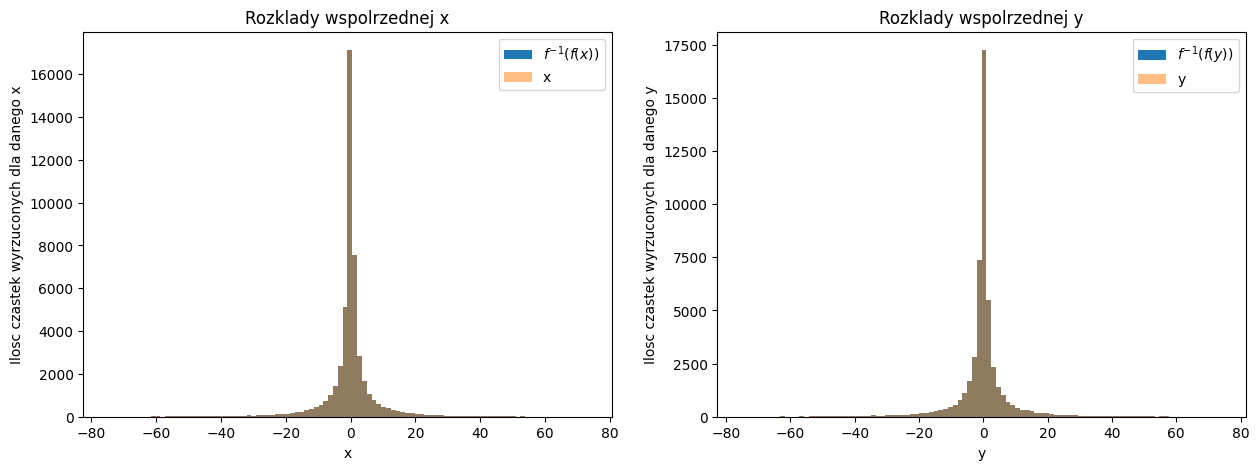

In [186]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title('Rozklady wspolrzednej x')
x_invr, _, _ = ax1.hist(inversed_np[:, 0], label=r'$f^{-1}(f(x))$', bins=100)
x_true, _, _ = ax1.hist(vector_input_np[:, 0], label=r'x', bins=100, alpha=0.5)
ax1.set_ylabel('Ilosc czastek wyrzuconych dla danego x')
ax1.set_xlabel('x')
ax1.legend()

ax2.set_title('Rozklady wspolrzednej y')
y_invr, _, _ = ax2.hist(inversed_np[:, 1], label=r'$f^{-1}(f(y))$', bins=100)
y_true, _, _ = ax2.hist(vector_input_np[:, 1], label=r'y', bins=100, alpha=0.5)
ax2.set_ylabel('Ilosc czastek wyrzuconych dla danego y')
ax2.set_xlabel('y')
ax2.legend()

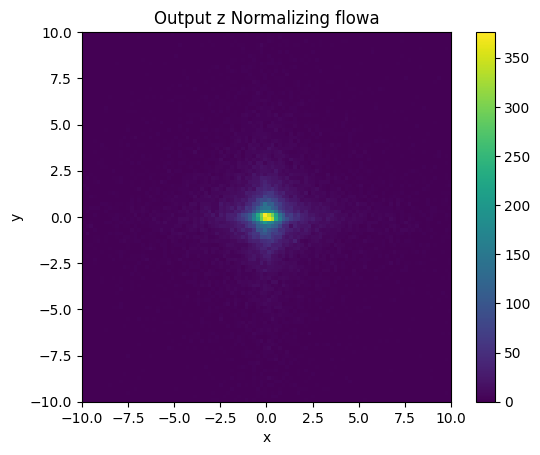

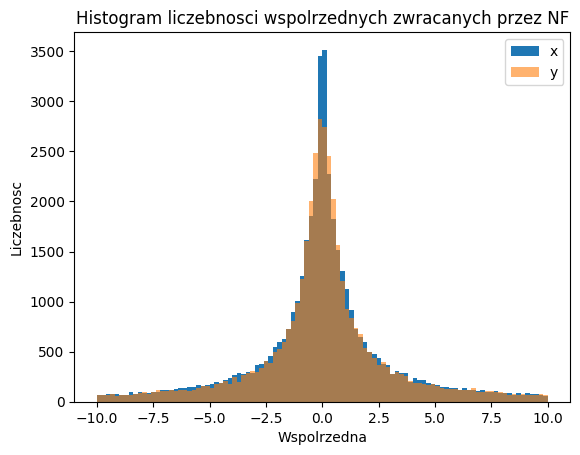

In [187]:
output_np = output.detach().numpy().reshape(-1, 2)
output_hist, x_edges, y_edges = np.histogram2d(output_np[:, 0], output_np[:, 1], range=[[-10, 10], [-10, 10]], bins=100)

plt.title('Output z Normalizing flowa')
plt.imshow(output_hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

plt.title('Histogram liczebnosci wspolrzednych zwracanych przez NF')
plt.hist(output_np[:, 0], label='x', range=[-10, 10], bins=100)
plt.hist(output_np[:, 1], label='y', range=[-10, 10], bins=100, alpha=0.6)
plt.xlabel('Wspolrzedna')
plt.ylabel('Liczebnosc')
plt.legend()
plt.show()